In [4]:
%load_ext autoreload
%autoreload all

# from multiprocessing.pool import ThreadPool as Pool
from multiprocessing.pool import Pool
from multiprocessing import freeze_support

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from snn_dpe.tools.data import util, Lorenz
from snn_dpe.tools.network import create_network, run_network_timeseries_nD, reset_network
from snn_dpe.tools.plotting import *
from snn_dpe.tools.plotting import plot_network, plot_spike_raster
from snn_dpe.tools.train.timeseries import (test_timeseries_nD,
                                            train_TS_nD)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# slice up MG into input, output pairs
input_window_size = 30
output_window_size = 1

n_tr_data = 2000
n_te_data = 1000


# NOTE: tmax/n defines the resolution of the data and the speed of the particle
LD_data = Lorenz.create_dataset(x0=10,y0=11,z0=11.05,tmax=50,n=n_tr_data+n_te_data, normalize=False)
LD_max = np.max(LD_data)
LD_min = np.min(LD_data)
# split data into training and testing
LD_data_tr = LD_data[:n_tr_data] 
LD_data_te = LD_data[n_te_data:] 

LD_inputs_tr, LD_outputs_tr = util.generate_io_pairs(LD_data_tr, input_window_size, output_window_size)
LD_inputs_te, LD_outputs_te = util.generate_io_pairs(LD_data_te, input_window_size, output_window_size)


def run_test(args):
    tr_mses = []
    te_mses = []

    np.random.seed()

    noise_axis = np.linspace(0, 0.1, num=3)

    for n in noise_axis:

        # create a test network
        n_neurons = 50
        synapse_density = 0.1
        n_input = 12 #how many neurons will receive potentiation adjustments related to MG
        n_synapses = int((n_neurons**2)*synapse_density)

        # dpe noise
        write_noise = n
        # synapse parameters
        drift = 0
        synapse_noise = 0

        # training parameters
        n_epochs = 5
        post_sample_reset = True #also applies to testing
        reset_synapses = True #also applies to testing
        post_epoch_reset = False
        LD_inputs_te_noise = LD_inputs_te + np.random.normal(0, 0)

        neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.25), weight_factor = 1, std_dev=synapse_noise, drift = drift)
        # train
        training_mses, testing_mses, _, _ = train_TS_nD(n_epochs, LD_inputs_tr, LD_outputs_tr, neurons, n_input, silent=True, TS_inputs_te=LD_inputs_te_noise, TS_outputs_te=LD_outputs_te, relative=True, write_noise_std=write_noise, post_sample_reset=post_sample_reset, reset_synapses=reset_synapses, post_epoch_reset=post_epoch_reset)
        
        # save the final mses of the last epoch
        tr_mses.append(training_mses[-1] / (LD_max-LD_min))
        te_mses.append(testing_mses[-1] / (LD_max-LD_min))

    return tr_mses, te_mses, noise_axis


n_tests = 1
n_threads = 5
with Pool(processes=n_threads) as p:
    results = list(tqdm(p.imap(run_test, range(n_tests)), total=n_tests))
    


100%|██████████| 1/1 [14:48<00:00, 888.07s/it]


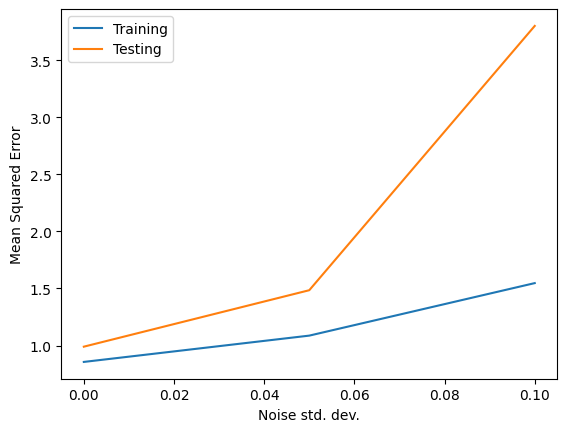

In [6]:
(tr_mses, te_mses, noise_axis) = np.mean(results, axis=0)



plt.plot(noise_axis, tr_mses, label='Training')
plt.plot(noise_axis, te_mses, label='Testing')
plt.legend()
plt.xlabel('Noise std. dev.')
plt.ylabel('Mean Squared Error')
# plt.ylim(0, 100)
# plt.yscale('log')
plt.show()

In [9]:
import csv

for i, r in enumerate(results):
    with open(f'./noise_results/Lorenz/write_noise/LD_noise_vs_MSE_write_noise_{i+30}.csv', 'w') as f:
        wtr = csv.writer(f, delimiter=',', lineterminator='\n')
        
        for data in zip(r[0], r[1], r[2]):
            wtr.writerow(list(data))

(1, 3)
[1.48462209]


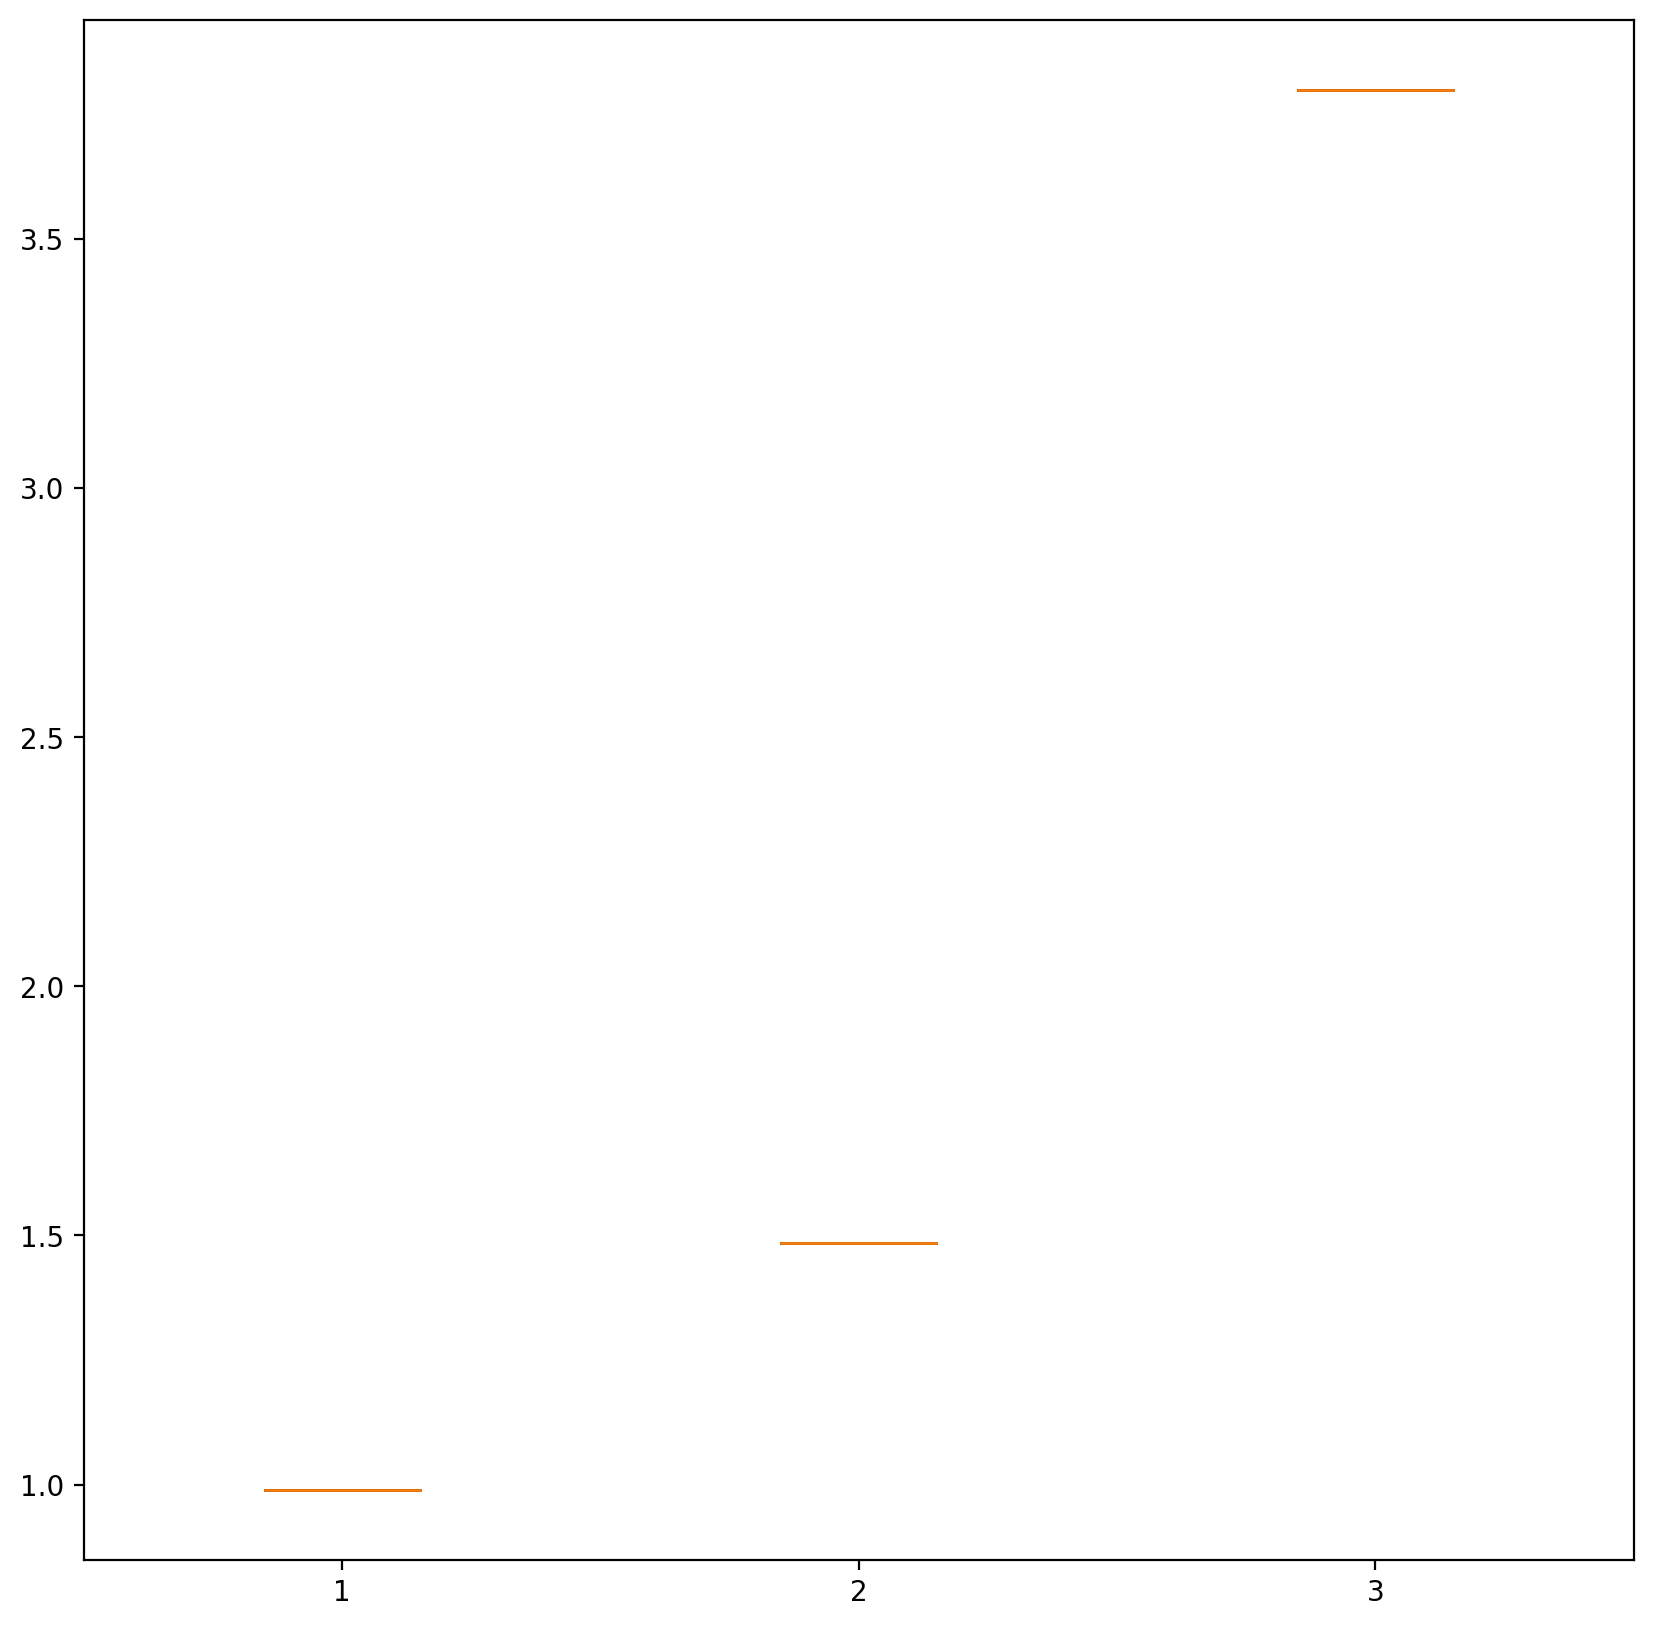

In [8]:
all_tr_mses = []

for r in results:
    all_tr_mses.append([])
    for d in r[1]:
        all_tr_mses[-1].append(d)
fig = plt.subplots(figsize=(10,10), dpi=200)
all_tr_mses = np.asarray(all_tr_mses)
print(all_tr_mses.shape)
print(all_tr_mses[:,1])
plt.boxplot(all_tr_mses)
plt.show()